# Import necessary libraries

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load and Explore the Datasets

In [2]:
# Load the training and test datasets
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

In [3]:
# Display the first few rows of the training data
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
### Language Counts
# Get the count of each language
language_counts = train_df['lang_id'].value_counts()

# Display the counts
print(language_counts)

lang_id
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: count, dtype: int64


The dataframe is prefectly balanced 

# Text Preprocessing

In [5]:
# Lowercasing
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

# Removing Punctuation
train_df['text'] = train_df['text'].str.replace('[^\w\s]', '')
test_df['text'] = test_df['text'].str.replace('[^\w\s]', '')

# Removing Numbers
train_df['text'] = train_df['text'].str.replace('\d+', '')
test_df['text'] = test_df['text'].str.replace('\d+', '')

# Model Training

In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['lang_id'], test_size=0.2, random_state=42)

In [7]:
# Initialize the TF-IDF vectorizer for unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)


I used unigrams and bigrams so that the model can learn from the context of the words. 

### Support Vector Machine (SVM) Model 

In [8]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred = svm_model.predict(X_val_tfidf)

# Evaluate the SVM model
print("Support Vector Machine Classification Report:")
print(classification_report(y_val, y_pred))
print("Mean F1-Score (SVM):", f1_score(y_val, y_pred, average='micro'))

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.99      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       0.98      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Mean F1-Score (SVM): 0.9963636363636363


### Naive Bayes Model

In [9]:
# Fit and transform the TF-IDF vectorizer on the training set
# Fit and transform the TF-IDF vectorizer on the training set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Initialize and train the Multinomial Naive Bayes model with specified hyperparameters
nb_model = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)
nb_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_nb = nb_model.predict(X_val_tfidf)

# Evaluate the Naive Bayes model
print("Naive Bayes Classification Report:")
print(classification_report(y_val, y_pred_nb))
print("Mean F1-Score (Naive Bayes):", f1_score(y_val, y_pred_nb, average='micro'))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      1.00      1.00       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Mean F1-Score (Naive Bayes): 0.9984848484848485


### Hyperparameter Tuning for Naive Bayes

In [10]:
# Get the unique classes from the training set
unique_classes = y_train.unique()

# Define a range of hyperparameters to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
    'class_prior': [None] + [1/len(unique_classes)] * len(unique_classes),  # Default and uniform class priors
}

# Initialize GridSearchCV for Naive Bayes
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters for Naive Bayes:", grid_search.best_params_)

# Make predictions on the validation set using the best model
y_pred_nb = grid_search.best_estimator_.predict(X_val_tfidf)

# Evaluate the Naive Bayes model with tuned hyperparameters
print("Naive Bayes Classification Report (Tuned):")
print(classification_report(y_val, y_pred_nb))
print("Mean F1-Score (Naive Bayes, Tuned):", f1_score(y_val, y_pred_nb, average='macro'))

C:\Users\rooke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
550 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
550 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rooke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rooke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Best Hyperparameters for Naive Bayes: {'alpha': 0.5, 'class_prior': None, 'fit_prior': False}
Naive Bayes Classification Report (Tuned):
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      1.00      1.00       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600

Mean F1-Score (Naive Bayes, Tuned): 0.998469284283

the reccomended best parameters for Naive Bayes: {'alpha': 0.5, 'class_prior': None, 'fit_prior': False} will be added to the model above. 

### Random Forest Model

In [10]:
### Random Forest Model
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_tfidf)

# Evaluate the Random Forest model
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))
print("Mean F1-Score (Random Forest):", f1_score(y_val, y_pred_rf, average='micro'))


Random Forest Classification Report:
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       0.99      1.00      0.99       615
         nbl       0.99      0.95      0.97       583
         nso       1.00      0.99      0.99       625
         sot       1.00      1.00      1.00       618
         ssw       0.99      0.96      0.98       584
         tsn       0.99      0.99      0.99       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.96      0.98       609
         zul       0.90      0.97      0.94       590

    accuracy                           0.98      6600
   macro avg       0.99      0.98      0.98      6600
weighted avg       0.99      0.98      0.99      6600

Mean F1-Score (Random Forest): 0.985


In [20]:
from sklearn.metrics import make_scorer

# Define a smaller parameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search_rf = GridSearchCV(
    rf_model, 
    param_grid, 
    scoring=make_scorer(f1_score, average='micro'),
    cv=3,  # 3-fold cross-validation for faster results
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search to the training data
grid_search_rf.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

# Make predictions on the validation set using the best model
y_pred_rf_tuned = grid_search_rf.best_estimator_.predict(X_val_tfidf)

# Evaluate the tuned Random Forest model
print("Tuned Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf_tuned))
print("Mean F1-Score (Tuned Random Forest):", f1_score(y_val, y_pred_rf_tuned, average='micro'))

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       0.99      1.00      1.00       615
         nbl       0.98      0.96      0.97       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      0.98      0.99       584
         tsn       0.99      1.00      0.99       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.98      0.98       609
         zul       0.94      0.98      0.96       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600

Mean F1-Score (Tuned Random Forest

In [23]:
# Updated Random Forest Model with Best Hyperparameters
best_rf_params = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
rf_model_updated = RandomForestClassifier(**best_rf_params, random_state=42)

# Train the updated Random Forest model
rf_model_updated.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_rf_updated = rf_model_updated.predict(X_val_tfidf)

# Evaluate the updated Random Forest model
print("Updated Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf_updated))
print("Updated Mean F1-Score (Random Forest):", f1_score(y_val, y_pred_rf_updated, average='micro'))

Updated Random Forest Classification Report:
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       0.99      1.00      1.00       615
         nbl       0.98      0.96      0.97       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      0.98      0.99       584
         tsn       0.99      1.00      0.99       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.98      0.98       609
         zul       0.94      0.98      0.96       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600

Updated Mean F1-Score (Random Forest): 0.9895454545454545


### Logistic Regression Model

In [11]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=100, random_state=42, multi_class='ovr')
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_val_tfidf)

# Evaluate the Logistic Regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))
print("Mean F1-Score (Logistic Regression):", f1_score(y_val, y_pred_lr, average='macro'))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         afr       1.00      0.99      0.99       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.98      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       0.99      1.00      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.98      0.99      0.99       609
         zul       0.98      0.98      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600

Mean F1-Score (Logistic Regression): 0.9938694890035886


## Model Performance evaluation 

### Confusion Matrix

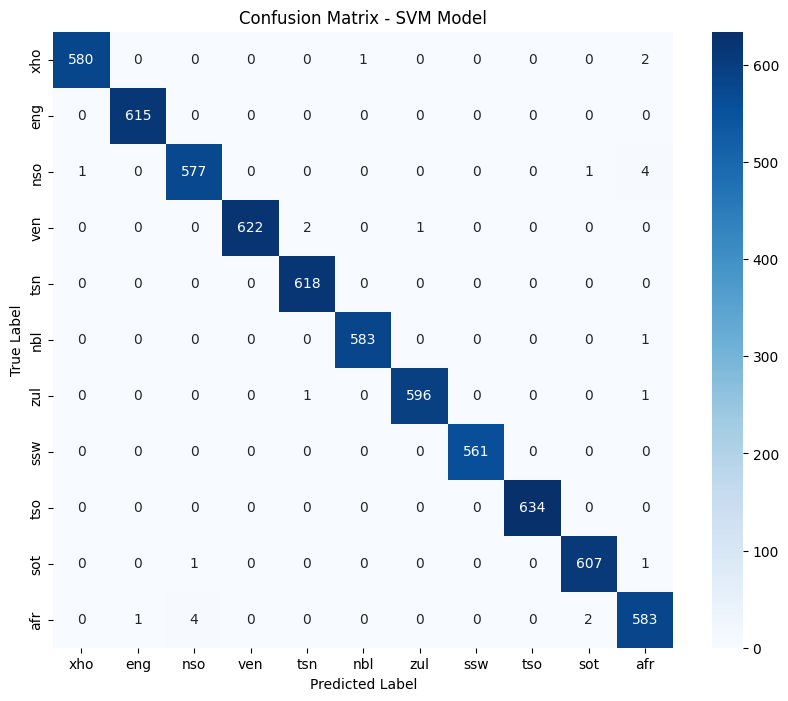

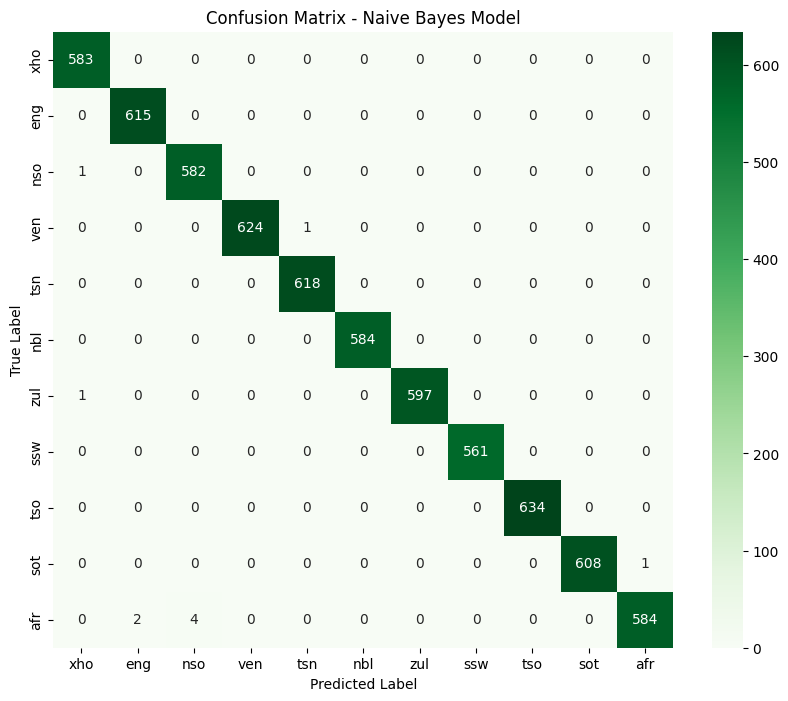

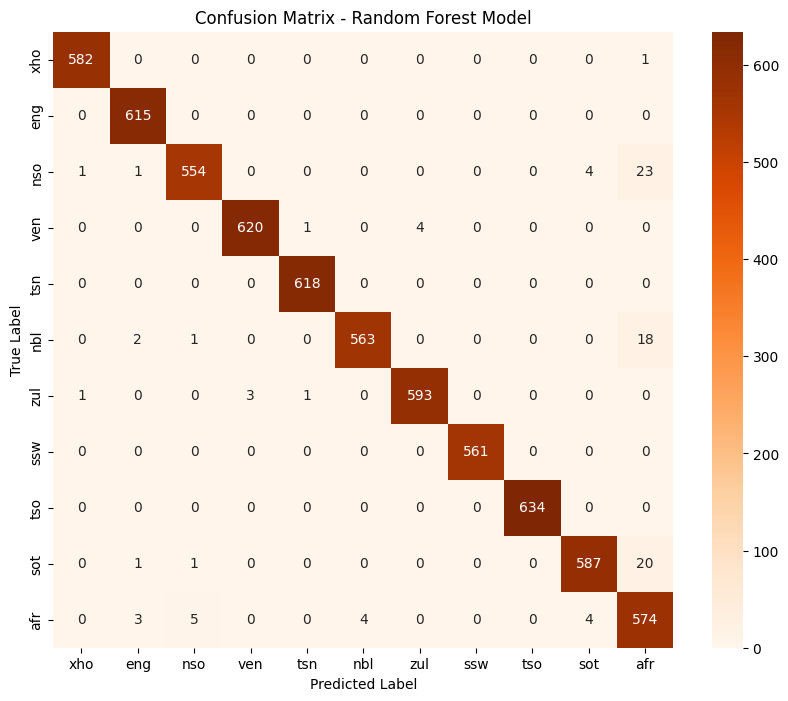

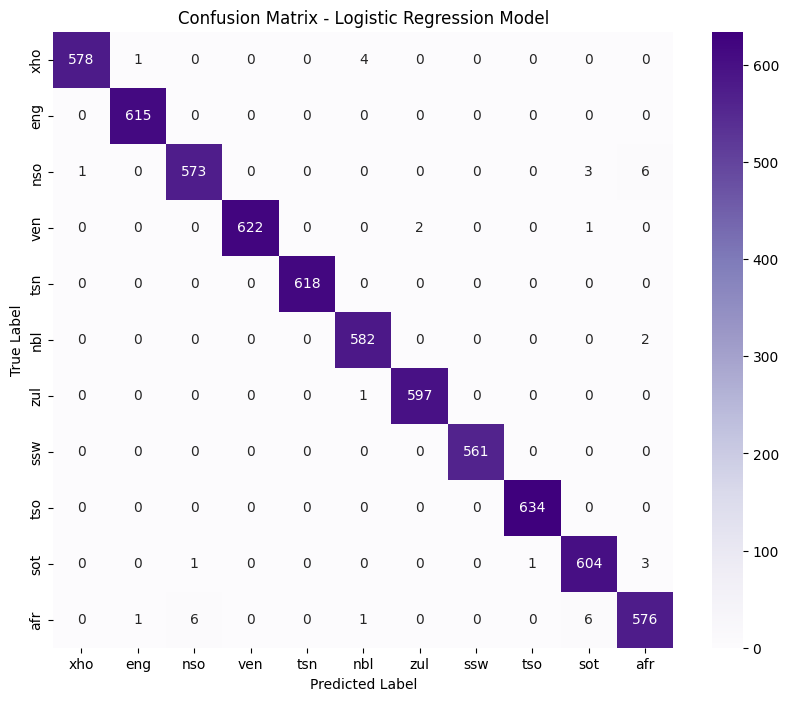

In [15]:
# Confusion Matrix for SVM Model
conf_matrix_svm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=language_counts.index, yticklabels=language_counts.index)
plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion Matrix for Naive Bayes Model
conf_matrix_nb = confusion_matrix(y_val, y_pred_nb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Greens", xticklabels=language_counts.index, yticklabels=language_counts.index)
plt.title("Confusion Matrix - Naive Bayes Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Oranges", xticklabels=language_counts.index, yticklabels=language_counts.index)
plt.title("Confusion Matrix - Random Forest Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Purples", xticklabels=language_counts.index, yticklabels=language_counts.index)
plt.title("Confusion Matrix - Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



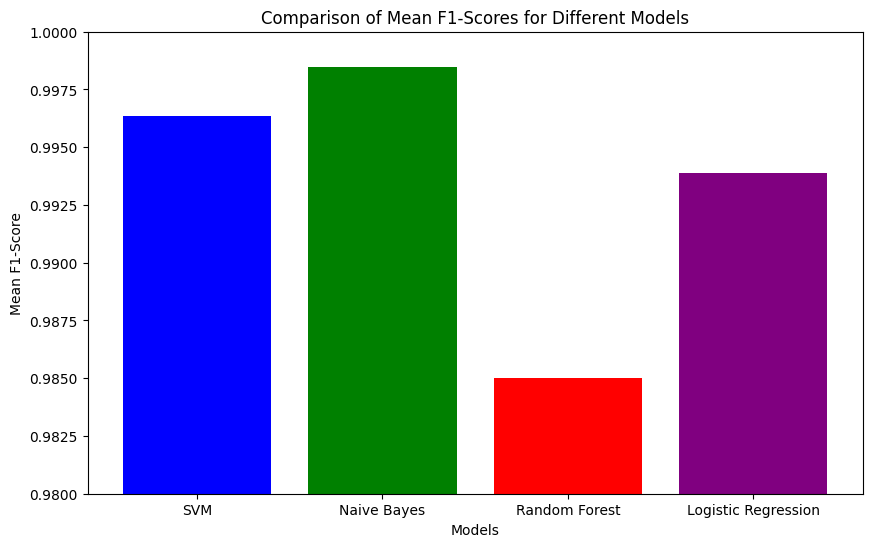

In [21]:
# Mean F1-Scores
f1_scores = [0.9963636363636363, 0.9984848484848485, 0.985, 0.9938694890035886]
models = ['SVM', 'Naive Bayes', 'Random Forest', 'Logistic Regression']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.title('Comparison of Mean F1-Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('Mean F1-Score')
plt.ylim(0.98, 1.0)  # Set the y-axis limits for better visualization
plt.show()

## Modelling on Test Data and Submission Generation

### SVM Model Submission

In [13]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_svm = tfidf_vectorizer.transform(test_df['text'])
# Make predictions on the test set using SVM
test_predictions_svm = svm_model.predict(X_test_tfidf_svm)

# Create a submission DataFrame for SVM
submission_df_svm = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_svm})

# Save the submission file for SVM
submission_df_svm.to_csv('submission_svm.csv', index=False)

### Naive Bayes Model Submission

In [14]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_nb = tfidf_vectorizer.transform(test_df['text'])

# Make predictions on the test set using Naive Bayes
test_predictions_nb = nb_model.predict(X_test_tfidf_nb)

# Create a submission DataFrame for Naive Bayes
submission_df_nb = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_nb})

# Save the submission file for Naive Bayes
submission_df_nb.to_csv('submission_nb_with_ngrams.csv', index=False)

### Random Forest Model Submission

In [ ]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_rf_updated = tfidf_vectorizer.transform(test_df['text'])

# Make predictions on the test set using the Random Forest model with best hyperparameters
test_predictions_rf_updated = rf_model_updated.predict(X_test_tfidf_rf_updated)

# Create a submission DataFrame for Random Forest with best hyperparameters
submission_df_rf_updated = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_rf_updated})

# Save the submission file for Random Forest with best hyperparameters
submission_df_rf_updated.to_csv('submission_rf_best_params.csv', index=False)

# Display a preview of the submission DataFrame
submission_df_rf_updated.head()

In [26]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_rf = tfidf_vectorizer.transform(test_df['text'])

# Make predictions on the test set using the updated Random Forest model
test_predictions_rf_updated = rf_model_updated.predict(X_test_tfidf_rf)

# Create a submission DataFrame for the updated Random Forest model
submission_df_rf_updated = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_rf_updated})

# Save the submission file for the updated Random Forest model
submission_df_rf_updated.to_csv('submission_rf_updated.csv', index=False)


### Logistic Regression Model Submission

In [16]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_lr = tfidf_vectorizer.transform(test_df['text'])

# Make predictions on the test set using Logistic Regression
test_predictions_lr = lr_model.predict(X_test_tfidf_lr)

# Create a submission DataFrame for Logistic Regression
submission_df_lr = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_lr})

# Save the submission file for Logistic Regression
submission_df_lr.to_csv('submission_lr.csv', index=False)

In [17]:
# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf_lr = tfidf_vectorizer.transform(test_df['text'])

# Make predictions on the test set using Logistic Regression
test_predictions_lr = lr_model.predict(X_test_tfidf_lr)

# Create a submission DataFrame
submission_df_lr = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions_lr})

# Save the submission file for Logistic Regression
submission_df_lr.to_csv('submission_lr.csv', index=False)
